In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
import sys
from helper_functions import set_seeds


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['daisy','dandelion']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output     

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [5]:
train_dir = 'C:/Users/xxvis/OneDrive/Desktop/Projects/python_ws/custom_dataset/train'
test_dir = 'C:/Users/xxvis/OneDrive/Desktop/Projects/python_ws/custom_dataset/test'

In [6]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [9]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

c:\Users\xxvis\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:50<16:38, 110.92s/it]

Epoch: 1 | train_loss: 0.2334 | train_acc: 0.8974 | test_loss: 0.1403 | test_acc: 0.9432


 20%|██        | 2/10 [03:38<14:33, 109.17s/it]

Epoch: 2 | train_loss: 0.1267 | train_acc: 0.9544 | test_loss: 0.1062 | test_acc: 0.9631


 30%|███       | 3/10 [05:28<12:44, 109.23s/it]

Epoch: 3 | train_loss: 0.1064 | train_acc: 0.9627 | test_loss: 0.0861 | test_acc: 0.9716


 40%|████      | 4/10 [07:16<10:53, 108.89s/it]

Epoch: 4 | train_loss: 0.0905 | train_acc: 0.9692 | test_loss: 0.0735 | test_acc: 0.9744


 50%|█████     | 5/10 [09:01<08:57, 107.55s/it]

Epoch: 5 | train_loss: 0.0818 | train_acc: 0.9737 | test_loss: 0.0673 | test_acc: 0.9801


 60%|██████    | 6/10 [10:48<07:09, 107.43s/it]

Epoch: 6 | train_loss: 0.0725 | train_acc: 0.9764 | test_loss: 0.0577 | test_acc: 0.9830


 70%|███████   | 7/10 [12:36<05:22, 107.51s/it]

Epoch: 7 | train_loss: 0.0665 | train_acc: 0.9791 | test_loss: 0.0508 | test_acc: 0.9858


 80%|████████  | 8/10 [14:30<03:39, 109.59s/it]

Epoch: 8 | train_loss: 0.0604 | train_acc: 0.9808 | test_loss: 0.0498 | test_acc: 0.9886


 90%|█████████ | 9/10 [16:24<01:51, 111.08s/it]

Epoch: 9 | train_loss: 0.0562 | train_acc: 0.9836 | test_loss: 0.0453 | test_acc: 0.9858


100%|██████████| 10/10 [18:10<00:00, 109.09s/it]

Epoch: 10 | train_loss: 0.0530 | train_acc: 0.9846 | test_loss: 0.0418 | test_acc: 0.9915


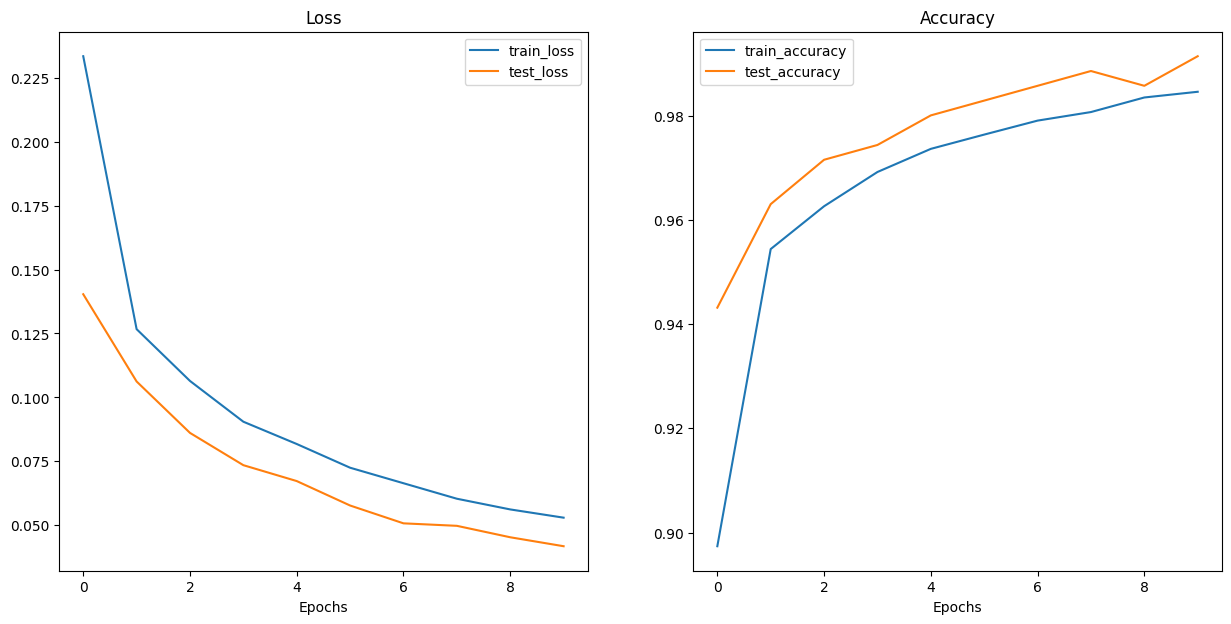

In [11]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)